# ETF Predictions

This Notebook will contain all of our data visualization and analysis. The main aim of the project is to classify whether an ETF will go up or down. This Notebook will contain the following 
- Data Visualization
- Analysis
- Combined ETF Analysis
- Conclusion

#### Importing required libraries

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import Feature_Creation
from Feature_Creation import create_features
from Feature_Creation import mc_pvalue
import Reproducing_Liew_Mayster
from Reproducing_Liew_Mayster import create_frame
from Reproducing_Liew_Mayster import liew_mayster
from Reproducing_Liew_Mayster import create_frame_rand
warnings.filterwarnings('ignore')
plotfolder = os.path.join(os.path.abspath(os.getcwd()),'plots')

## Data Visualization

We inported the ETF data from Yahoo Finance. The data we consider is for the 5 year time perion from 12/31/2014 to12/30/2019 . We consider the followinf 10 ETF's (SPY, IWM, EEM, TLT, LQD, TIP, IYR, GLD, OIH, FXE). Let us begin by visualizing the ETF's performance over 5 years

In [2]:
ETF_list = ['SPY', 'IWM', 'EEM', 'TLT', 'LQD', 'TIP', 'IYR', 'GLD', 'OIH', 'FXE']

SPY = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','SPY.csv'))
IWM = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','IWM.csv'))
EEM = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','EEM.csv'))
TLT = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','TLT.csv'))
LQD = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','LQD.csv'))
TIP = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','TIP.csv'))
IYR = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','IYR.csv'))
GLD = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','GLD.csv'))
OIH = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','OIH.csv'))
FXE = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','FXE.csv'))

SPY.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,207.990005,208.190002,205.389999,205.539993,184.358871,130333800
1,2015-01-02,206.380005,206.880005,204.179993,205.429993,184.260223,121465900
2,2015-01-05,204.169998,204.369995,201.350006,201.720001,180.932541,169632600
3,2015-01-06,202.089996,202.720001,198.860001,199.820007,179.228363,209151400
4,2015-01-07,201.419998,202.720001,200.880005,202.309998,181.461731,125346700


#### Example plot of SPY

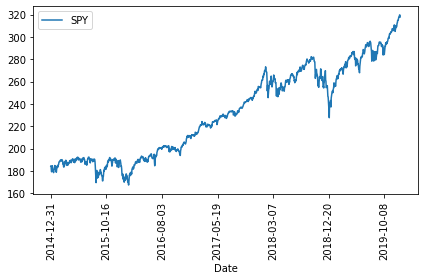

In [3]:
SPY.plot(x='Date',y='Adj Close',rot=90,label='SPY')
plt.legend()
plt.tight_layout()
plt.savefig('SPY.png')

#### Comparative normalized plot where we put the starting ETF price to 1

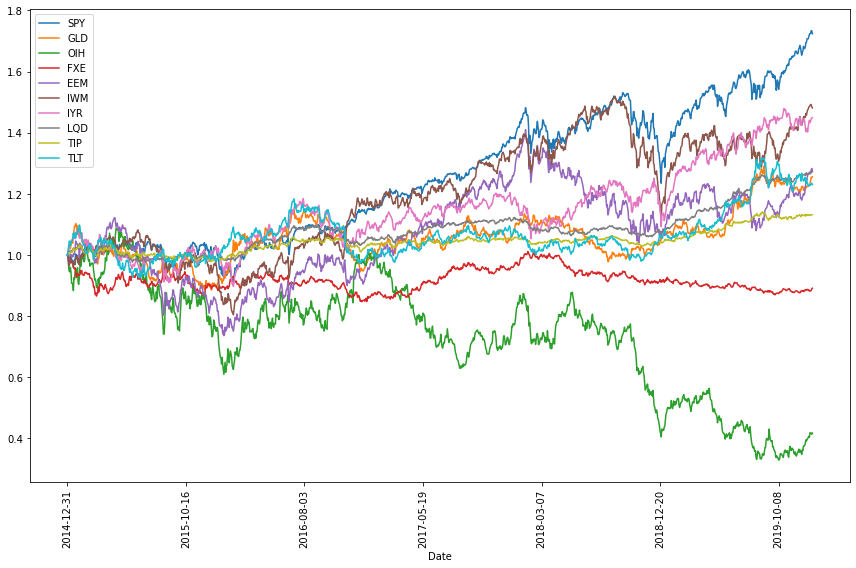

In [4]:
ETF_list_plot = ['GLD','OIH','FXE','EEM','IWM','IYR','LQD','TIP','TLT']
SPY['Adj Close'] = SPY['Adj Close']/SPY['Adj Close'].iloc[0]
ax = SPY.plot(x = 'Date',y = 'Adj Close',rot = 90, figsize = (12,8),label = 'SPY')
for etf in ETF_list_plot:
    df = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF',etf+'.csv'))
    df['Adj Close'] = df['Adj Close']/df['Adj Close'].iloc[0] 
    df.plot(x = 'Date', y = 'Adj Close', rot = 90, label = etf,ax=ax)
plt.legend()
plt.tight_layout()

### Feature Creation 
Now we will create features for an ETF and explore the possibility of different features influencing whether the EFT will go upor down over our target horizon. We will choose our target horizon to be 1 day. We will use SPY for our exploration. We will begin by creating features that will be a proxy for stock momentum and may hold predictive power. We create the following features
-  Dummy variables for month and day of the week
-  Previous 1, 2, 3, 4, 5 and 7 day percent changes of the price
-  Cumulative sum of the 1 day percent changes
-  7, 50 and 200 day exponentially weighted moving average (EWMA)
-  Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD)
-  Day's variances (High-Low), (Open- Close), (Open - Previous Close), (High - Close)
-  Previous Hot  (Cold) Streak (previous no. of consecutive days when the ETF went up (down))
-  Current Hot (Cold) Streak (no. of consecutive days when the ETF went up (down) in the ongoing streak)
-  Permutations of differences in Previous and Current, Hot and Cold streaks

In [5]:
SPY_feat = create_features(SPY)
SPY_feat.drop(['Date','Open','High','Low','Open','Close','Adj Close'],inplace=True,axis=1)


continuous = SPY_feat.columns[SPY_feat.nunique() >100]
discrete = SPY_feat.columns[SPY_feat.nunique() < 100]

scaler = StandardScaler()
SPY_cont = pd.DataFrame(scaler.fit_transform(SPY_feat[continuous]),columns=continuous)

SPY_disc = SPY_feat[discrete]

SPY_cont.reset_index(drop=True,inplace=True)

SPY_disc.reset_index(drop=True,inplace=True)

SPY_feat = pd.concat([SPY_cont,SPY_disc],axis=1)

SPY_feat.head()

,Volume,1day_pct,2day_pct,3day_pct,4day_pct,5day_pct,7day_pct,1day_pct_cs,ewma_7,ewma_50,...,RSI_overbought,RSI_oversold,prev_hot_streak,prev_cold_streak,current_hot_streak,current_cold_streak,prev_current_hot,prev_current_cold,current_hot_prev_cold,current_cold_prev_hot
0,1.089399,-0.986095,-1.422394,0.017497,0.756615,0.124171,-0.848936,-1.371593,0.537024,0.573669,...,False,False,2.0,3.0,0.0,2.0,2.0,1.0,-3.0,0.0
1,2.575900,-0.390597,-0.983883,-1.417095,-0.189291,0.501131,-0.958688,-1.386954,0.656686,0.658355,...,False,False,2.0,3.0,0.0,3.0,2.0,0.0,-3.0,1.0
2,2.119037,-0.773034,-0.831653,-1.278448,-1.632389,-0.538465,-0.370326,-1.419927,1.013978,0.860448,...,False,False,2.0,3.0,0.0,4.0,2.0,-1.0,-3.0,2.0
3,1.772034,-1.143478,-1.367842,-1.371706,-1.702129,-2.015223,-0.357646,-1.469960,1.545046,1.168710,...,False,True,2.0,3.0,0.0,5.0,2.0,-2.0,-3.0,3.0
4,2.519249,1.498322,0.244696,-0.259540,-0.430185,-0.856927,-0.326254,-1.398334,0.107701,0.581467,...,False,False,2.0,5.0,1.0,0.0,1.0,5.0,-4.0,-2.0


#### For continuous features we can plot the distribution depending if the target is 0 or 1

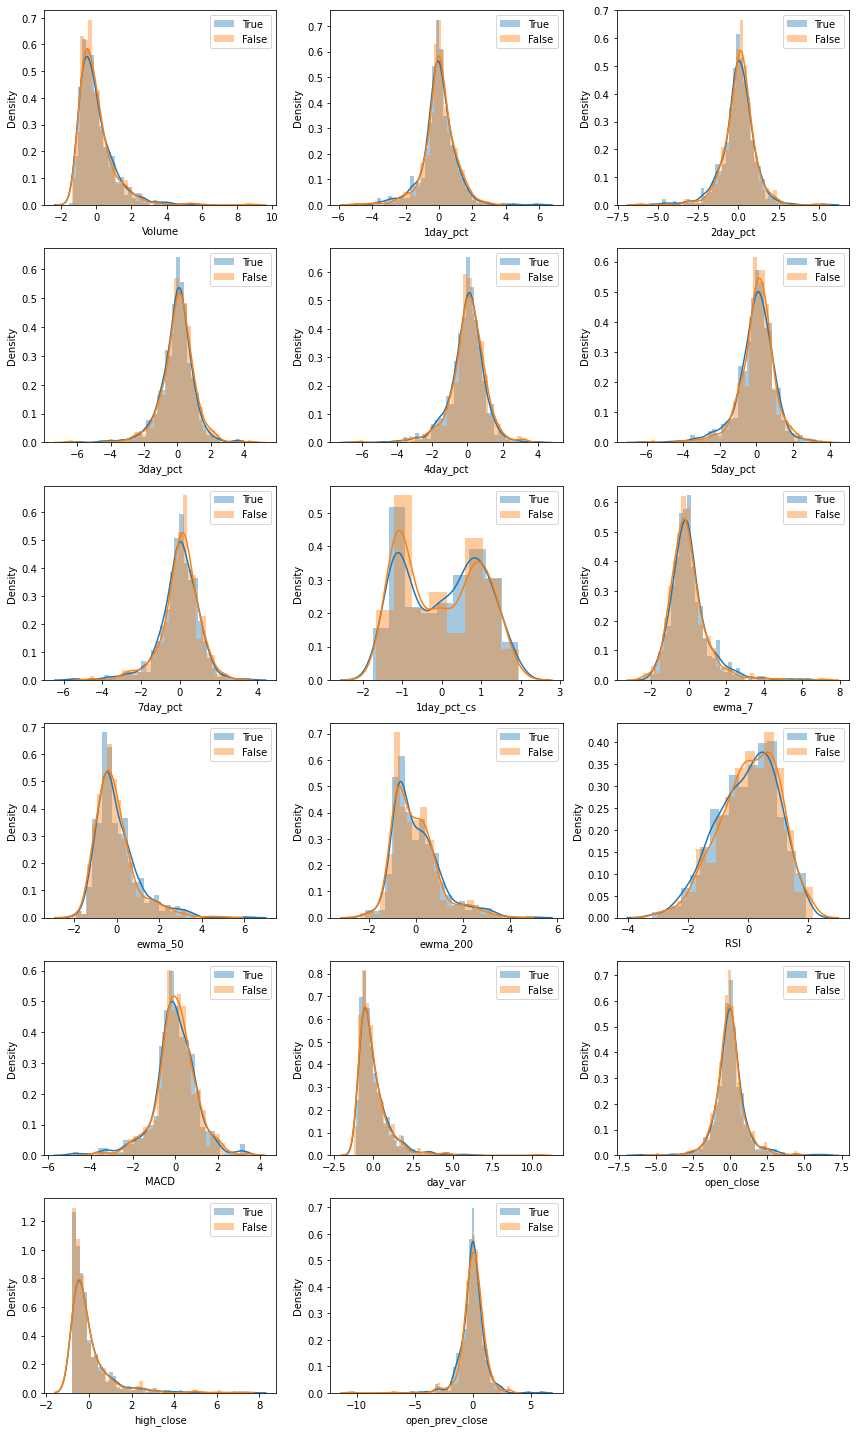

In [6]:
df_True = SPY_feat[SPY_feat.target==True]
df_False = SPY_feat[SPY_feat.target==False]

fig = plt.figure(figsize=(12,20))

for i,col in enumerate(continuous):
    plt.subplot(6,3,i+1);
    sns.distplot(df_True[col],label='True');
    sns.distplot(df_False[col],label='False');
    plt.legend()
    plt.tight_layout()

#### Dependence of target on discrete variables

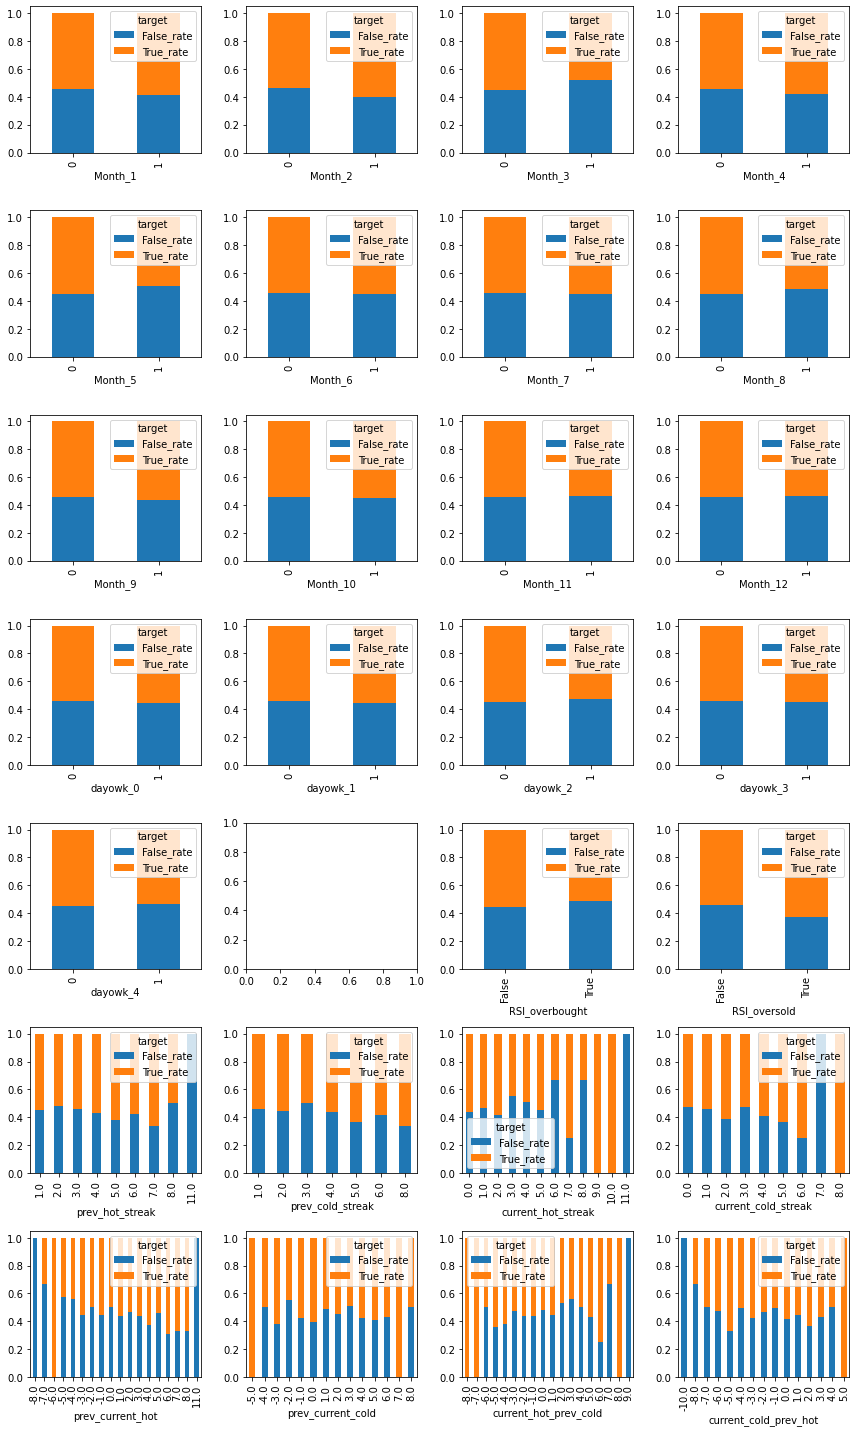

In [7]:
fig, axes = plt.subplots(7,4, figsize=(12,20))
axes = axes.ravel()
for i,col in enumerate(discrete):
    if col!='target':
        df2 = SPY_feat.groupby([col, 'target'])[col].count().unstack('target').fillna(0)
        df2['False_rate'] = df2[0]/(df2[0]+df2[1])
        df2['True_rate'] = df2[1]/(df2[0]+df2[1])
        df2[['False_rate','True_rate']].plot(kind='bar',stacked=True,ax=axes[i])
plt.tight_layout()

As we can see the dependence on continuous or discrete variables is not strong.

Now let us find if any correlation exists between different ETF's. We will do this by correlating the 1_day pct change. As we can see  ETF's can have strong positive or mild negative correlations

#### Correlation among ETF's 1 day change

<AxesSubplot:>

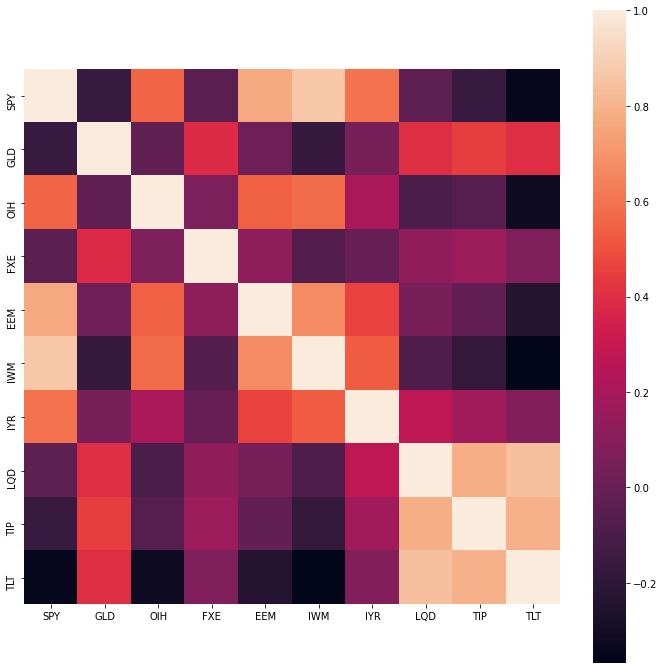

In [204]:
ETF_list_plot = [GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT]
ETF_list_plot_str = ['GLD','OIH','FXE','EEM','IWM','IYR','LQD','TIP','TLT']
df = pd.DataFrame()
df['SPY'] = SPY_feat['1day_pct']
for i,etf in enumerate(ETF_list_plot):
    data = create_features(etf)
    df[ETF_list_plot_str[i]] = data['1day_pct'] 

plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),vmax=1.,square=True)

### Generating Baseline random ETFs
We create 5 random ETF's by simulating a random walk with changes in daily prices drawn from a gaussian distribution with the standard deviation of SPY daily percent changes. We have arepresentative samples of random ETFs that go up, down or stay more or less constant over the 5 year period. Below we plot them and correlations among them. As can be seen the random ETF's have no correlations among themselves

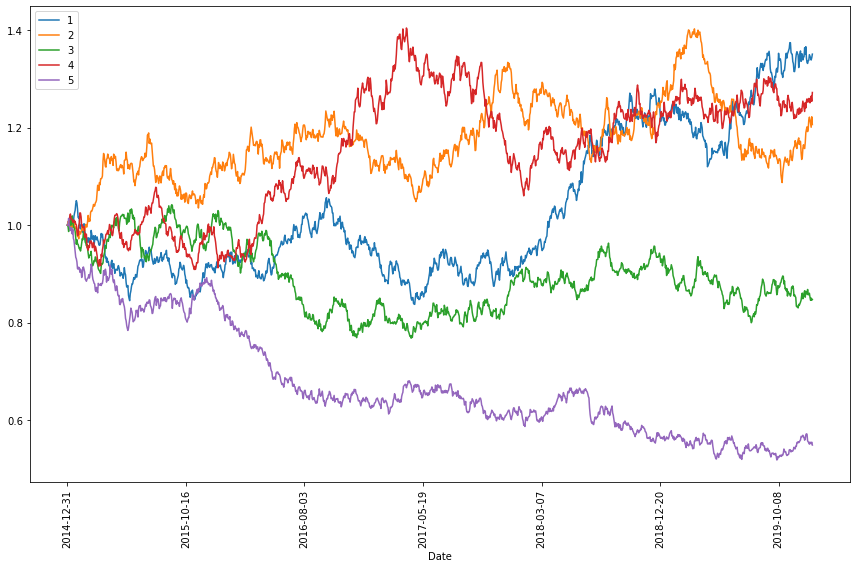

In [9]:
random1 = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random1.csv'))
random2 = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random2.csv'))
random3 = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random3.csv'))
random4 = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random4.csv'))
random5 = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random5.csv'))
ax = random1.plot(x = 'Date', y = 'Adj Close',label='1',rot=90,figsize = (12,8))
random2.plot(x = 'Date', y = 'Adj Close',ax=ax,label='2',rot=90)
random3.plot(x = 'Date', y = 'Adj Close',ax=ax,label='3',rot=90)
random4.plot(x = 'Date', y = 'Adj Close',ax=ax,label='4',rot=90)
random5.plot(x = 'Date', y = 'Adj Close',ax=ax,label='5',rot=90)
plt.legend()
plt.tight_layout()

In [231]:
((np.sign(df['random1'])+1)/2==1).sum()/df.shape[0]

0.5144

<AxesSubplot:>

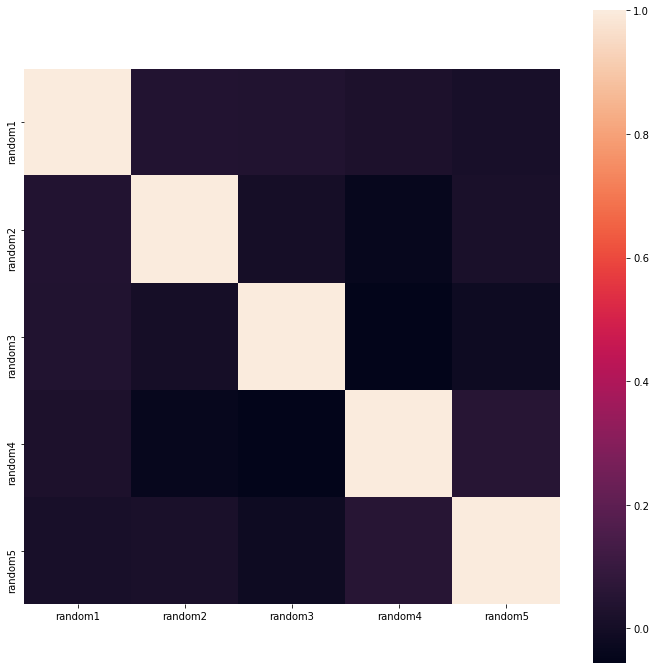

In [225]:
ETF_list_plot = [random1,random2,random3,random4,random5]
ETF_list_plot_str = ['random1','random2','random3','random4','random5']
df = pd.DataFrame()
for i,etf in enumerate(ETF_list_plot):
    data = create_features(etf)
    df[ETF_list_plot_str[i]] = data['1day_pct'] 

plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),vmax=1.,square=True)

## Daily Prediction Analysis

We will perform classification by using the following 4 algorithms, Random Forests, Logistic Regression, Support Vector Machines and Gradient Boost.
**Random Forest**
Number of trees - 100 (Given that all other hyperparameters are same, increasing number of trees just reduces the statistical variance in prediction, and choosing large enough number of trees is sufficient)
Criterion - [gini, entropy] (Criterion for selecting feature at each node)
Max Depth - [None, 2, 3, 5, 10] Depth of the trees built
min_samples_split - [5,10,15] minimum samples at a node to split it
min_samples_leaf - [3,5,9,13] minimum samples required in a leaf

**XGBoost**
max_depth: range (2, 10, 2),
n_estimators: range(20, 120, 20),
learning_rate: [0.001,0.003,0.01, 0.03, 0.1]

**Logistic Regression**
fit_intercept: [True,False],
solver:['liblinear'],
C: np.logspace(0,4,5),
penalty: ['l2']

**Support Vector Machine**
coef0 =  np.array([0.25,0.5, 1,2,4])
gamma =  np.array([0.0001,0.001, 0.01,0.1])
degree = np.array([2,3, 4])

**Methodology**
In our analysis we don't respect the fact that the ETF is a time series since the historyof the data is encoded in the features. Instead of a time series cross-validation, we perform k-fold cross-validation. We then use a criterion which we call "Information Gain" (IG) defined as the difference between the accuracy predicted by our models and expected accuracy by randomly generating the probablility distribution suggested by the training set. Since we use this criterion throughout the analysis we will describe our choice here in some detail.

$IG = ModelAccuracy - F(x,y)$

where $F(x,y) = x*y -(1-x)*(1-y)$ is the expected accuracy where  x is the number of positives in the test set and y is the number of positives in the training set. Note that this definition comes from the assumption that our algorithms at minimum have learned the probability distribution of our training set, (i.e. it knows the fraction of positioves and negatives) and tries to randomly predict that on our test set. This metric of "Information Gain" is a little convoluted compared to that of just Model Accuracy, or Model Accuracy - Naive Accuracy, where Naive accuracy is accuracy with precision of 1 i.e. predict all positives. But as we will show with our randomly generated data as an example, our definition does not penalize stocks that go significantly up or down. 
On each data set (ETF's or random data) we then perform a train-test split multiple times to generate a distribution of Information Gain. Comparing the Information Gain between our ETFs and randomly generated ETFs we can distinguish our strategies

### Random ETF analysis

In the interest of clear explanation, the generation of information gain distributions has been done elsewhere (See the Analysis Notebooks). Here we will import the results and perform statistical anaylsis. First we begin with the results of our algorithms on the random ETF's. Note we will be showing the KDE in the plots but for actual statistical analysis we will be using the underlying data

#### Information Gain definition example 

We will being by demonstrating why our definition of information gain is better than other naive defintions we could have used. Since random1 increases the most and random5 decreases the most we will use them for our example. We will also use SVM model.

In [234]:
def IG(acc,x,y):
    """Information Gain given model accuracy, test acuuracy and train accuracy"""
    return acc - x*y - (1-x)*(1-y)

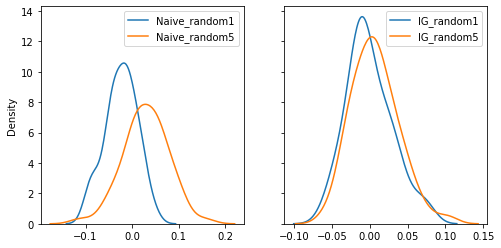

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
random_ETF_list_var = [random1,random5]
random_ETF_list = ['random1','random5']
etf_acc_list = []
for etf in random_ETF_list_var:
    etf_feat = create_features(etf)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])
for i,etf in enumerate(random_ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','analysis_results',etf)) as json_file:
        data = json.load(json_file)
        NaiveIG = []
        IGlist = []
        for j in range(60):
            NaiveIG.append(data[j][1]['information gain'])
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            IGlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
        sns.distplot([NaiveIG],hist = False,ax = axes[0],label = 'Naive_' + etf)
        axes[0].legend()
        sns.distplot([IGlist],hist = False,ax = axes[1],label = 'IG_' + etf)
        axes[1].legend()


As we can see above our definition of information gain centers the ditribution, aligns and lowers the std deviation. The also don't get penalized for having a higher positive rate as random1 gets penalized more than random5 in our naive definition. This alignment will be more eveident when we discuss higher differences in positive rates for larger horizons. Now we will show the information gain with each alogorithm for all the random data sets

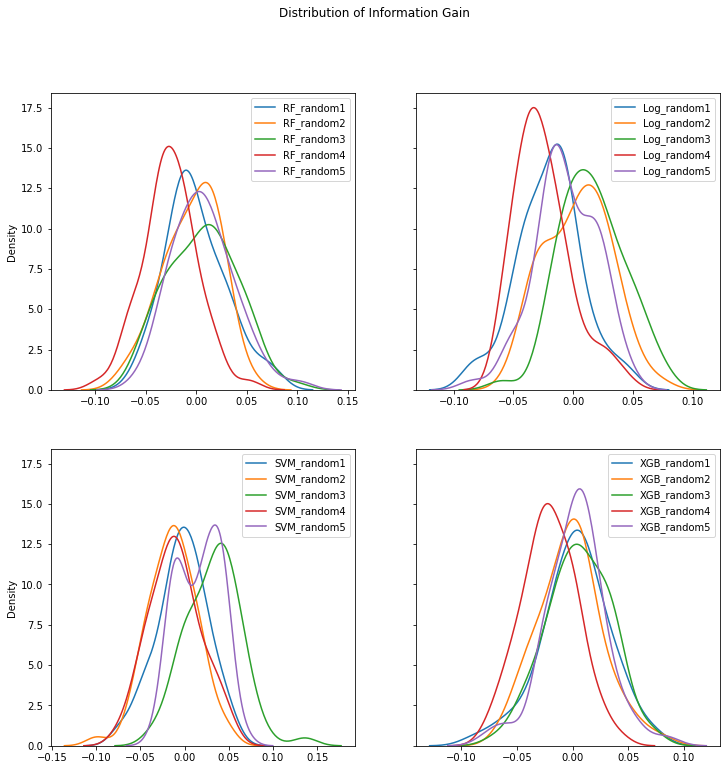

In [322]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
random_ETF_list_var = [random1,random2,random3,random4,random5]
random_ETF_list = ['random1','random2','random3','random4','random5']
etf_acc_list = []
for etf in random_ETF_list_var:
    etf_feat = create_features(etf)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

random_etf_df = pd.DataFrame()
for i,etf in enumerate(random_ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','analysis_results',etf)) as json_file:
        data = json.load(json_file)
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        random_etf_df['RF_'+str(i+1)] = RFlist
        random_etf_df['Log_'+str(i+1)] = Loglist
        random_etf_df['SVM_'+str(i+1)] = SVMlist
        random_etf_df['XGB_'+str(i+1)] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain')
plt.savefig(plotfolder+'/IG_new')

### ETF Analysis
Now let us repeat the same analysis for our actual ETF's

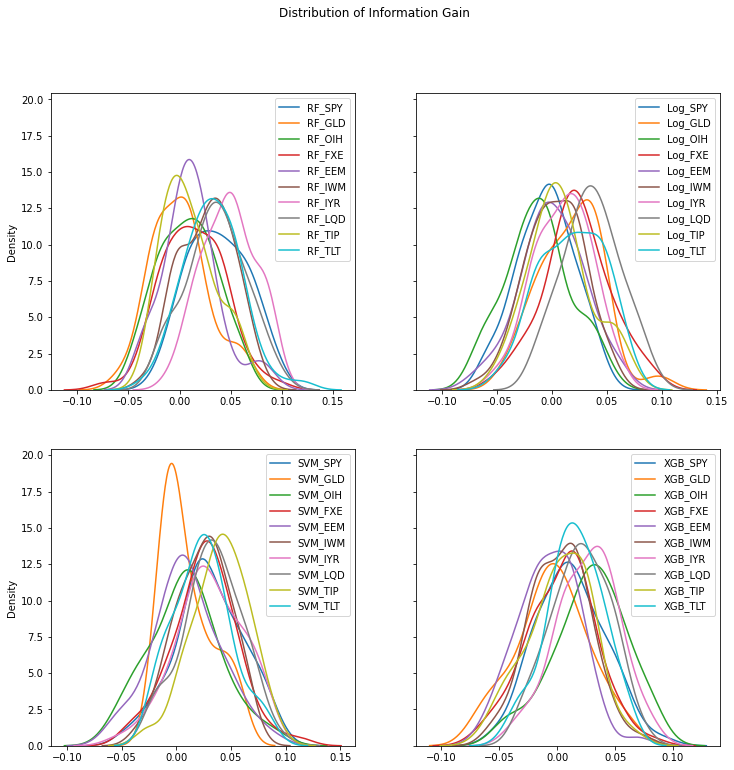

In [323]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
ETF_list_var = [SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT]
ETF_list = ['SPY','GLD','OIH','FXE','EEM','IWM','IYR','LQD','TIP','TLT']
etf_acc_list = []
for etf in ETF_list_var:
    etf_feat = create_features(etf)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

etf_df = pd.DataFrame()
for i,etf in enumerate(ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','analysis_results',etf)) as json_file:
        data = json.load(json_file)
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        etf_df['RF_'+etf] = RFlist
        etf_df['Log_'+etf] = Loglist
        etf_df['SVM_'+etf] = SVMlist
        etf_df['XGB_'+etf] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain')
plt.savefig(plotfolder+'/IG_etf_new')

### Statistical comparison
The idea here is whether our information gain can distinguish between a random ETF and an actual ETF. If it cannot then our analysis works as well on a random data set than an actual data set, and since by definition there is no way to predict the daily changes in a random ETF we have no predictive power. We use Monte Carlo for our statistical test where we take the distributions we are to compare, merge them, then split the merged distributions randomly into sizes of the original dataframe. We then subtract the means of the split distributions. Repeating this process a lot of times generates a distribution of mean differences that is normally distributed. We then count the percentage of mean differences that were greater than the mean difference of our original data sets which is our p value. The power of the Monte Carlo approach is that it is a non-parametric test and no assumptions are made about the underlying distribution. The Monte-Carlo function is defined elsewhere for presentation purposes, here we only use it.

We compare apples to apples i.e. RF IG distribution for SPY will be compared to RF IG distribution for all the 5 random ETF's. We then take the highest p-value (least distinguishable). If the highest p-value is still < 0.05 we consider that a possible signal might exist for a given ETF and method. In the table below we show the p-value and the random etf which generated that p-value

In [307]:
p_val_dict = {}
for etf in ETF_list:
    RF_list = []
    Log_list = []
    SVM_list = []
    XGB_list = []
    for i in range(5):
        if etf_df['RF_'+etf].mean() > random_etf_df['RF_'+str(i+1)].mean():
            RF_list.append(mc_pvalue(etf_df['RF_'+etf],random_etf_df['RF_'+str(i+1)]))
        else:
            RF_list.append(np.inf)
        if etf_df['Log_'+etf].mean() > random_etf_df['Log_'+str(i+1)].mean():
            Log_list.append(mc_pvalue(etf_df['Log_'+etf],random_etf_df['Log_'+str(i+1)]))
        else:
            Log_list.append(np.inf)
        if etf_df['SVM_'+etf].mean() > random_etf_df['SVM_'+str(i+1)].mean():
            SVM_list.append(mc_pvalue(etf_df['SVM_'+etf],random_etf_df['SVM_'+str(i+1)]))
        else:
            SVM_list.append(np.inf)
        if etf_df['XGB_'+etf].mean() > random_etf_df['XGB_'+str(i+1)].mean():
            XGB_list.append(mc_pvalue(etf_df['XGB_'+etf],random_etf_df['XGB_'+str(i+1)]))
        else:
            XGB_list.append(np.inf)
    p_val_dict[etf] = [max(RF_list),max(Log_list),
                       max(SVM_list),max(XGB_list)]


analysis_result = pd.DataFrame.from_dict(p_val_dict)
analysis_result['Method'] = ['RF','Log','SVM','XGB']
analysis_result.set_index('Method')

,SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT
Method,,,,,,,,,,
RF,0.000,inf,0.459,0.192,0.264,0.004,0.0,0.000,0.318,0.000
Log,inf,0.383,inf,0.167,inf,inf,inf,0.001,inf,0.343
SVM,inf,inf,inf,inf,inf,inf,inf,0.488,0.113,inf
XGB,0.161,inf,0.001,inf,inf,inf,0.0,0.007,inf,0.055


We ignore the inf entries, they are merely indicating that the mean of the real ETF is lower than at least one randomly generated ETF. Let us now plot the ETF's for which we actually might have a signal, i.e. even the closest random information gain distribution is not close enough to give a higher p-value

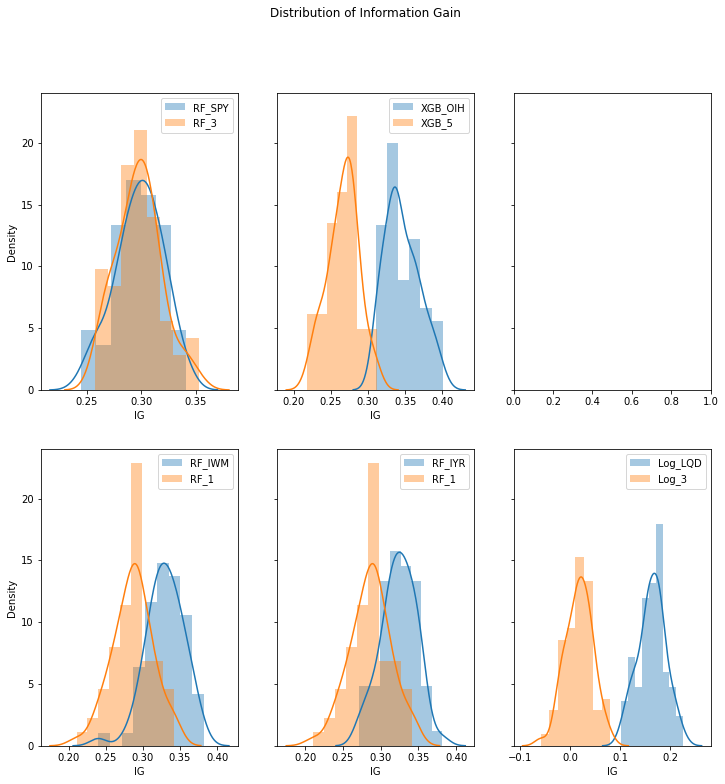

In [379]:
fig, axes = plt.subplots(2, 3, figsize=(12, 12), sharey=True)
fig.suptitle('Distribution of Information Gain')    
sns.distplot([etf_df['RF_'+'SPY']],kde=True,ax = axes[0,0],label = 'RF_'+'SPY');
sns.distplot([random_etf_df['RF_'+'3']],kde=True,ax = axes[0,0],label = 'RF_'+'3');
axes[0,0].set_xlabel('IG')
axes[0,0].legend()

sns.distplot([etf_df['XGB_'+'OIH']],kde=True,ax = axes[0,1],label = 'XGB_'+'OIH');
sns.distplot([random_etf_df['XGB_'+'5']],kde=True,ax = axes[0,1],label = 'XGB_'+'5');
axes[0,1].set_xlabel('IG')
axes[0,1].legend()

sns.distplot([etf_df['RF_'+'IWM']],kde=True,ax = axes[1,0],label = 'RF_'+'IWM');
sns.distplot([random_etf_df['RF_'+'1']],kde=True,ax = axes[1,0],label = 'RF_'+'1');
axes[1,0].set_xlabel('IG')
axes[1,0].legend()

sns.distplot([etf_df['RF_'+'IYR']],kde=True,ax = axes[1,1],label = 'RF_'+'IYR');
sns.distplot([random_etf_df['RF_'+'1']],kde=True,ax = axes[1,1],label = 'RF_'+'1');
axes[1,1].set_xlabel('IG')
axes[1,1].legend()

sns.distplot([etf_df['Log_'+'LQD']],kde=True,ax = axes[1,2],label = 'Log_'+'LQD');
sns.distplot([random_etf_df['Log_'+'3']],kde=True,ax = axes[1,2],label = 'Log_'+'3');
axes[1,2].set_xlabel('IG')
axes[1,2].legend()


plt.savefig(plotfolder+'/signal')

We find a signal in **SPY, OIH, IWM, IYR, LQD**. In most of the cases RF or XGB gives a positive signal.

**However** before making such a bold claim it's important to remember that our analysis only suggests that we might be able to get better **accuracy** compared to a random ETF, however our **returns** could be worse compared to zero. Also we only consider 5 different random ETF's. It's possible that considering more, we would get a p-value above our threshold of 0.05. A more detailed statistical analysis is needed to address this question.

Finally we need to implement this strategy in live markets to see it's potential. We will implement this in the future.

## Combined ETF Analysis

We have chosen 10 ETF's that represent a broad cross-section of the market. Assuming the ETF is a closed system (obviously it's not) one can imagine that the gain of one ETF is loss of another. As we already saw the ETF daily percdnt changes can have significant correlations among themselves. Any correlations within ETF's should be exploited. Thus in this section we will do an analysis where we perform the analysis on all the ETF's combined. We will try to reproduce this paper by [Liew and Mayster](https://www.semanticscholar.org/paper/Forecasting-ETFs-with-Machine-Learning-Algorithms-Liew-Mayster/ec031b6d2445a3b9547c0dc33a822032c2f38233#citing-papers).

In the work cited above, the authors consider the change in the ETF price over a horizon "n". n takes the values [1,2,3,5,10,20,40,60,120,250] days. Then the following features are generated with P as the proce of the ETF on a given day and V it's volume 
- t lagged n day returns,  $X_A$ = {r(t-n,t), r(t-n-1,t-1),..., r(t-n-j,t-j)}, where r(t-n, t). = P(t-n)/P(t) -1
- t lagged n day average volumes $X_B$ = {V(t-n+1,t), V(t-n,t),..., V(t-n-j+1,t-j+1)}
- Dummy variables for month and week.

Combining all these features for all the 10 ETF's we can generate a dataframe to use our algorithms on.  One of the ETF's is then chosen as a target ETF.  In the paper, they describe a criterion for information gain which is a little different than the definition we used above. To calculate information gain, they replace the dataframe created above with a random dataframe from a univariate distribution between 0 and 1 for all the continuous features. Then the difference in accuracy between the ETF dataframe and the random data frame is called "Information Gain".  We will use our original definition of information gain, and we will compare the distribution of information gain from the ETF's vs the random data to see if we find a signal over differing time horizons.


#### Horizon = 1

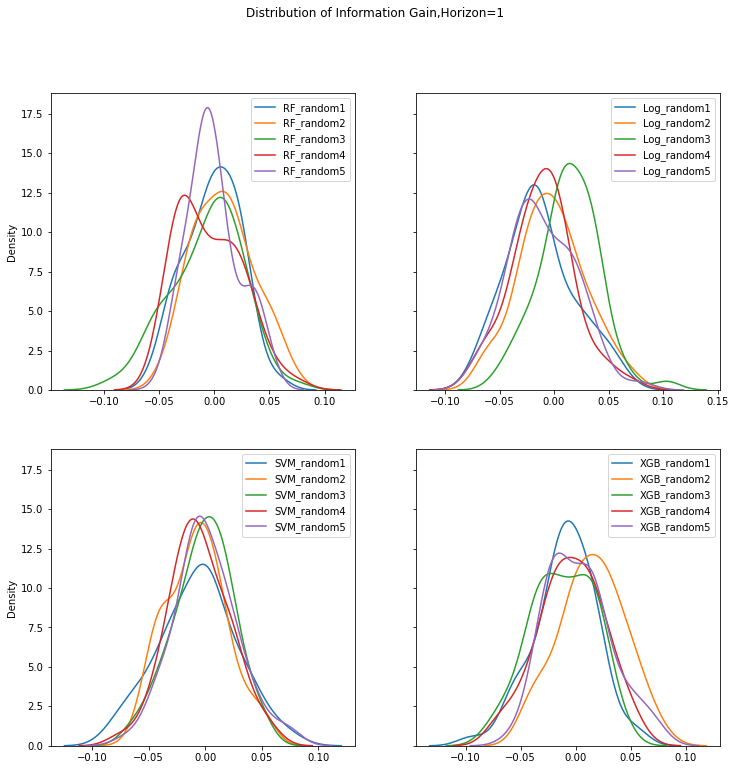

In [369]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
random_ETF_list = ['random1','random2','random3','random4','random5']
etf_acc_list = []
for etf in random_ETF_list:
    etf_feat = create_frame_rand(etf,horizon=1)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

random_etf_df = pd.DataFrame()
for i,etf in enumerate(random_ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','LW',etf+'_'+str(1))) as json_file:
        data = json.load(json_file)
        #ACC = []
        #NaiveIG = []
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        random_etf_df['RF_'+str(i+1)] = RFlist
        random_etf_df['Log_'+str(i+1)] = Loglist
        random_etf_df['SVM_'+str(i+1)] = SVMlist
        random_etf_df['XGB_'+str(i+1)] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain,Horizon=1')
plt.savefig(plotfolder+'/IG_LM_1')

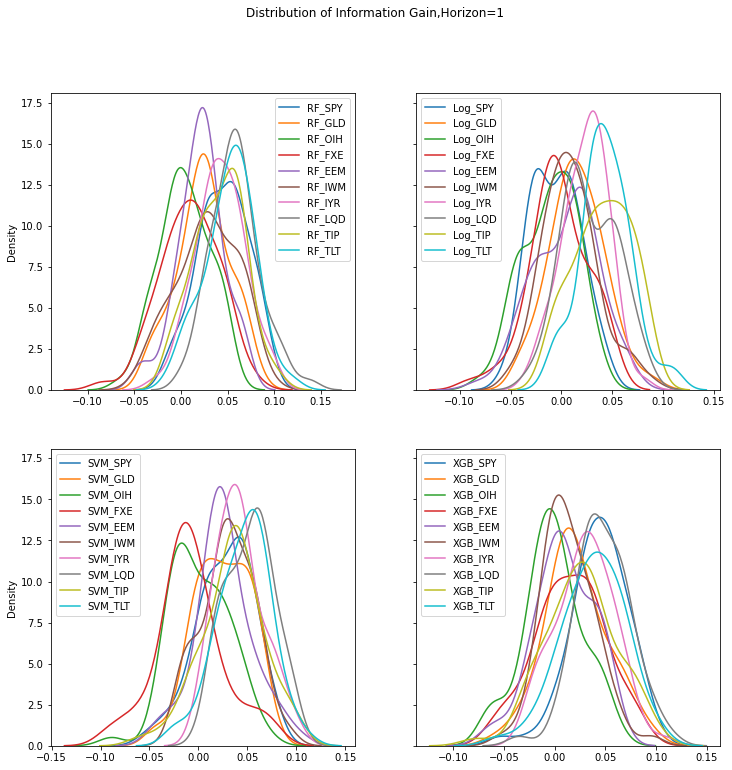

In [370]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
ETF_list_var = [SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT]
ETF_list = ['SPY','GLD','OIH','FXE','EEM','IWM','IYR','LQD','TIP','TLT']
etf_acc_list = []
for etf in ETF_list:
    etf_feat = create_frame(etf,horizon=1)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

etf_df = pd.DataFrame()
for i,etf in enumerate(ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','LW',etf+str(1))) as json_file:
        data = json.load(json_file)
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        etf_df['RF_'+etf] = RFlist
        etf_df['Log_'+etf] = Loglist
        etf_df['SVM_'+etf] = SVMlist
        etf_df['XGB_'+etf] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain,Horizon=1')
plt.savefig(plotfolder+'/IG_LM_etf_1')

In [371]:
p_val_dict = {}
for etf in ETF_list:
    RF_list = []
    Log_list = []
    SVM_list = []
    XGB_list = []
    for i in range(5):
        if etf_df['RF_'+etf].mean() > random_etf_df['RF_'+str(i+1)].mean():
            RF_list.append(mc_pvalue(etf_df['RF_'+etf],random_etf_df['RF_'+str(i+1)]))
        else:
            RF_list.append(np.inf)
        if etf_df['Log_'+etf].mean() > random_etf_df['Log_'+str(i+1)].mean():
            Log_list.append(mc_pvalue(etf_df['Log_'+etf],random_etf_df['Log_'+str(i+1)]))
        else:
            Log_list.append(np.inf)
        if etf_df['SVM_'+etf].mean() > random_etf_df['SVM_'+str(i+1)].mean():
            SVM_list.append(mc_pvalue(etf_df['SVM_'+etf],random_etf_df['SVM_'+str(i+1)]))
        else:
            SVM_list.append(np.inf)
        if etf_df['XGB_'+etf].mean() > random_etf_df['XGB_'+str(i+1)].mean():
            XGB_list.append(mc_pvalue(etf_df['XGB_'+etf],random_etf_df['XGB_'+str(i+1)]))
        else:
            XGB_list.append(np.inf)
    p_val_dict[etf] = [max(RF_list),max(Log_list),max(SVM_list),max(XGB_list)]


analysis_result = pd.DataFrame.from_dict(p_val_dict)
analysis_result['Method'] = ['RF','Log','SVM','XGB']
analysis_result.set_index('Method')

,SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT
Method,,,,,,,,,,
RF,0.0,0.004,inf,0.419,0.004,0.0,0.000,0.000,0.000,0.0
Log,inf,0.385,inf,inf,inf,inf,0.037,0.006,0.000,0.0
SVM,0.0,0.000,0.478,inf,0.000,0.0,0.000,0.000,0.000,0.0
XGB,0.0,0.182,inf,0.480,inf,inf,0.008,0.000,0.056,0.0


We ignore the inf entries, they are merely indicating that the mean of the real ETF is lower than at least one randomly generated ETF. All ETFs except GLD and OIH show p- values < 0.05. Curiously those are the pnes that have a negative growth over 5 years. Below we plot information gain of SPY for RF and XGB algorithms compared to the random ETF gains.

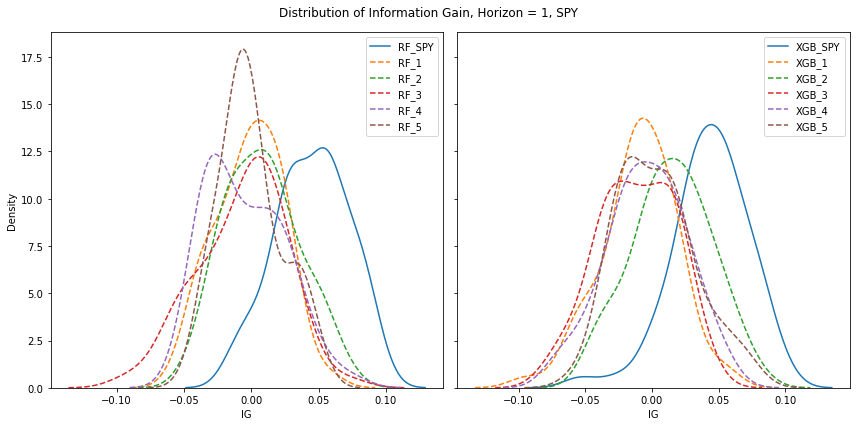

In [372]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Distribution of Information Gain, Horizon = 1, SPY')    
sns.distplot([etf_df['RF_'+'SPY']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'SPY');
sns.distplot([random_etf_df['RF_'+'1']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'1',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'2']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'2',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'3']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'3',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'4']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'4',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'5']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'5',kde_kws={'linestyle':'--'});
axes[0].set_xlabel('IG')
axes[0].legend()

sns.distplot([etf_df['XGB_'+'SPY']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'SPY');
sns.distplot([random_etf_df['XGB_'+'1']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'1',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'2']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'2',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'3']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'3',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'4']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'4',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'5']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'5',kde_kws={'linestyle':'--'});
axes[1].set_xlabel('IG')
axes[1].legend()

plt.tight_layout()
plt.savefig(plotfolder+'/horizon1_dist.png')

#### Horizon = 5 

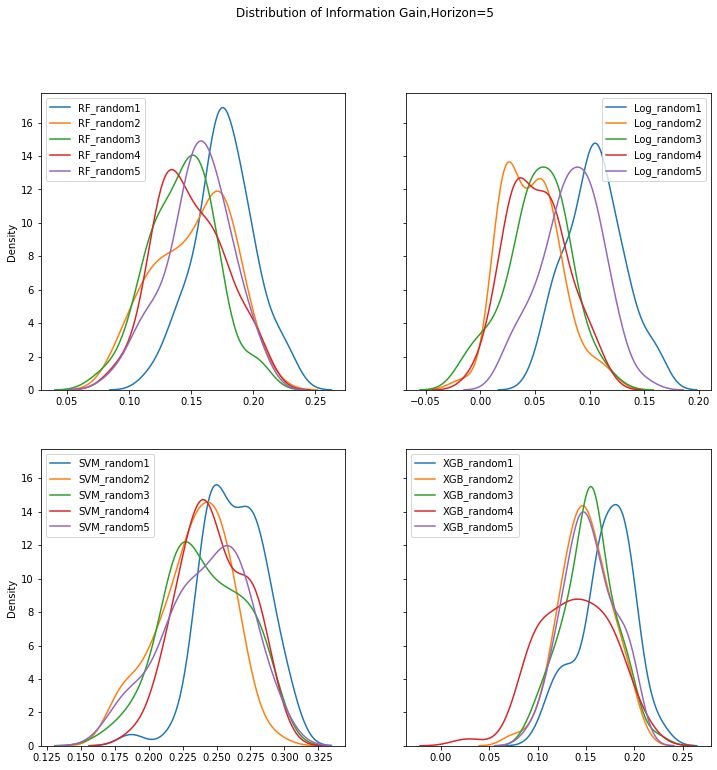

In [360]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
random_ETF_list = ['random1','random2','random3','random4','random5']
etf_acc_list = []
for etf in random_ETF_list:
    etf_feat = create_frame_rand(etf,horizon=5)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

random_etf_df = pd.DataFrame()
for i,etf in enumerate(random_ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','LW',etf+'_'+str(5))) as json_file:
        data = json.load(json_file)
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        random_etf_df['RF_'+str(i+1)] = RFlist
        random_etf_df['Log_'+str(i+1)] = Loglist
        random_etf_df['SVM_'+str(i+1)] = SVMlist
        random_etf_df['XGB_'+str(i+1)] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain,Horizon=5')
plt.savefig(plotfolder+'/IG_LM_5')

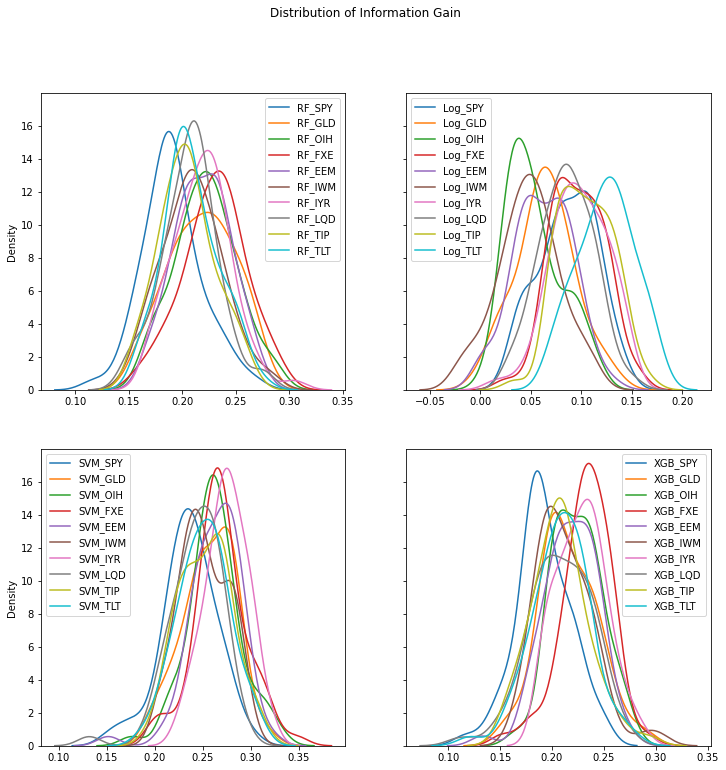

In [340]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
ETF_list_var = [SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT]
ETF_list = ['SPY','GLD','OIH','FXE','EEM','IWM','IYR','LQD','TIP','TLT']
etf_acc_list = []
for etf in ETF_list:
    etf_feat = create_frame(etf,horizon=5)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

etf_df = pd.DataFrame()
for i,etf in enumerate(ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','LW',etf+'_'+str(5))) as json_file:
        data = json.load(json_file)
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        etf_df['RF_'+etf] = RFlist
        etf_df['Log_'+etf] = Loglist
        etf_df['SVM_'+etf] = SVMlist
        etf_df['XGB_'+etf] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain')
plt.savefig(plotfolder+'/IG_LM_etf_5')

In [341]:
p_val_dict = {}
for etf in ETF_list:
    RF_list = []
    Log_list = []
    SVM_list = []
    XGB_list = []
    for i in range(5):
        if etf_df['RF_'+etf].mean() > random_etf_df['RF_'+str(i+1)].mean():
            RF_list.append(mc_pvalue(etf_df['RF_'+etf],random_etf_df['RF_'+str(i+1)]))
        else:
            RF_list.append(np.inf)
        if etf_df['Log_'+etf].mean() > random_etf_df['Log_'+str(i+1)].mean():
            Log_list.append(mc_pvalue(etf_df['Log_'+etf],random_etf_df['Log_'+str(i+1)]))
        else:
            Log_list.append(np.inf)
        if etf_df['SVM_'+etf].mean() > random_etf_df['SVM_'+str(i+1)].mean():
            SVM_list.append(mc_pvalue(etf_df['SVM_'+etf],random_etf_df['SVM_'+str(i+1)]))
        else:
            SVM_list.append(np.inf)
        if etf_df['XGB_'+etf].mean() > random_etf_df['XGB_'+str(i+1)].mean():
            XGB_list.append(mc_pvalue(etf_df['XGB_'+etf],random_etf_df['XGB_'+str(i+1)]))
        else:
            XGB_list.append(np.inf)
    p_val_dict[etf] = [max(RF_list),max(Log_list),max(SVM_list),max(XGB_list)]


analysis_result = pd.DataFrame.from_dict(p_val_dict)
analysis_result['Method'] = ['RF','Log','SVM','XGB']
analysis_result.set_index('Method')

,SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT
Method,,,,,,,,,,
RF,0.008,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.0
Log,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.0
SVM,inf,inf,inf,0.153,0.444,inf,0.009,inf,inf,inf
XGB,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.0


Entries with **inf** are not applicable since the mean of the ETF is lower than all the random ETF in that case. There are multiple entries with p < 0.05 for all ETF's. RF and XGB seem to give a signal for all ETF's while RF and XGB dont work for most ETF's. As an example we will plot SPY against random RF and XGB below.

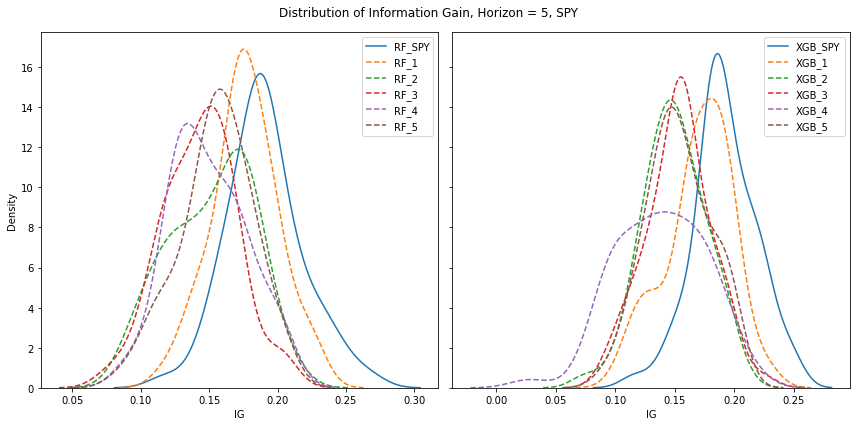

In [355]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Distribution of Information Gain, Horizon = 5, SPY')    
sns.distplot([etf_df['RF_'+'SPY']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'SPY');
sns.distplot([random_etf_df['RF_'+'1']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'1',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'2']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'2',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'3']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'3',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'4']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'4',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'5']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'5',kde_kws={'linestyle':'--'});
axes[0].set_xlabel('IG')
axes[0].legend()

sns.distplot([etf_df['XGB_'+'SPY']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'SPY');
sns.distplot([random_etf_df['XGB_'+'1']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'1',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'2']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'2',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'3']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'3',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'4']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'4',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'5']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'5',kde_kws={'linestyle':'--'});
axes[1].set_xlabel('IG')
axes[1].legend()

plt.tight_layout()
plt.savefig(plotfolder+'/horizon5_dist.png')


#### Horizon = 10

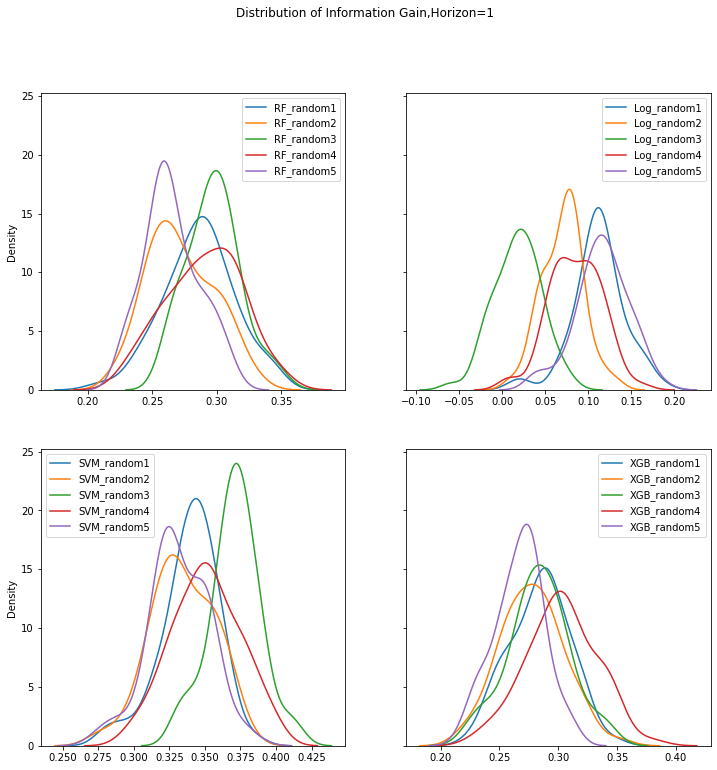

In [373]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
random_ETF_list = ['random1','random2','random3','random4','random5']
etf_acc_list = []
for etf in random_ETF_list:
    etf_feat = create_frame_rand(etf,horizon=10)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

random_etf_df = pd.DataFrame()
for i,etf in enumerate(random_ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','LW',etf+'_'+str(10))) as json_file:
        data = json.load(json_file)
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        random_etf_df['RF_'+str(i+1)] = RFlist
        random_etf_df['Log_'+str(i+1)] = Loglist
        random_etf_df['SVM_'+str(i+1)] = SVMlist
        random_etf_df['XGB_'+str(i+1)] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain,Horizon=1')
plt.savefig(plotfolder+'/IG_LM_10')

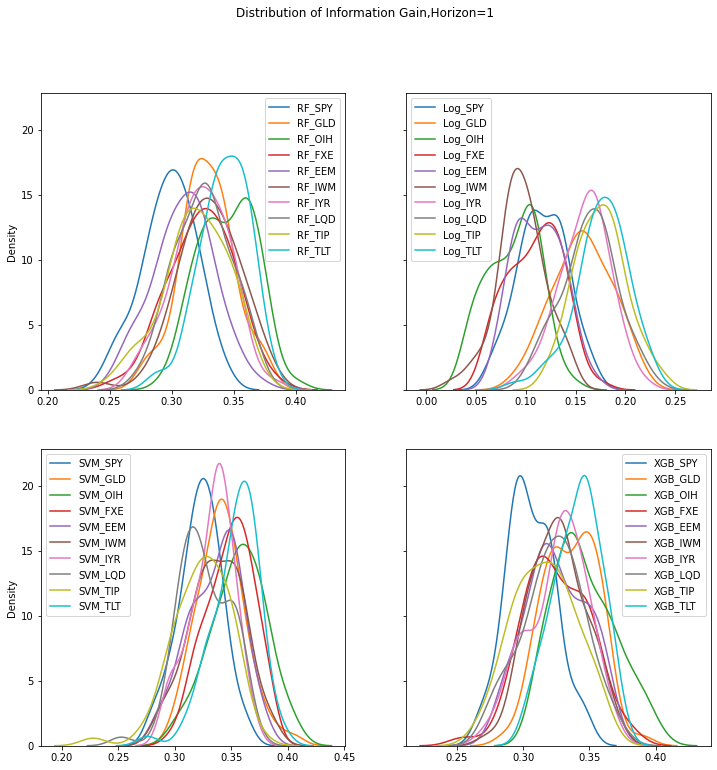

In [375]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
ETF_list_var = [SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT]
ETF_list = ['SPY','GLD','OIH','FXE','EEM','IWM','IYR','LQD','TIP','TLT']
etf_acc_list = []
for etf in ETF_list:
    etf_feat = create_frame(etf,horizon=10)
    etf_acc_list.append(etf_feat['target'].sum()/etf_feat.shape[0])

etf_df = pd.DataFrame()
for i,etf in enumerate(ETF_list):
    with open(os.path.join(os.path.abspath(os.getcwd()),'results','LW',etf+'_'+str(10))) as json_file:
        data = json.load(json_file)
        RFlist = []
        Loglist = []
        SVMlist = []
        XGBlist = []
        for j in range(60):
            testacc = data[j][0]['accuracy']
            trainacc = (etf_acc_list[i]-0.2*data[j][0]['accuracy'])/0.8
            RFlist.append(IG(data[j][1]['accuracy'],testacc,trainacc))
            Loglist.append(IG(data[j][2]['accuracy'],testacc,trainacc))
            SVMlist.append(IG(data[j][3]['accuracy'],testacc,trainacc))
            XGBlist.append(IG(data[j][4]['accuracy'],testacc,trainacc))
        etf_df['RF_'+etf] = RFlist
        etf_df['Log_'+etf] = Loglist
        etf_df['SVM_'+etf] = SVMlist
        etf_df['XGB_'+etf] = XGBlist
        sns.distplot([RFlist],hist = False,ax = axes[0,0],label = 'RF_' + etf)
        axes[0,0].legend()
        sns.distplot([Loglist],hist = False,ax = axes[0,1],label = 'Log_' + etf)
        axes[0,1].legend()
        sns.distplot([SVMlist],hist = False,ax = axes[1,0],label = 'SVM_' + etf)
        axes[1,0].legend()
        sns.distplot([XGBlist],hist = False,ax = axes[1,1],label = 'XGB_' + etf)
        axes[1,1].legend()
fig.suptitle('Distribution of Information Gain,Horizon=1')
plt.savefig(plotfolder+'/IG_LM_etf_10')

In [376]:
p_val_dict = {}
for etf in ETF_list:
    RF_list = []
    Log_list = []
    SVM_list = []
    XGB_list = []
    for i in range(5):
        if etf_df['RF_'+etf].mean() > random_etf_df['RF_'+str(i+1)].mean():
            RF_list.append(mc_pvalue(etf_df['RF_'+etf],random_etf_df['RF_'+str(i+1)]))
        else:
            RF_list.append(np.inf)
        if etf_df['Log_'+etf].mean() > random_etf_df['Log_'+str(i+1)].mean():
            Log_list.append(mc_pvalue(etf_df['Log_'+etf],random_etf_df['Log_'+str(i+1)]))
        else:
            Log_list.append(np.inf)
        if etf_df['SVM_'+etf].mean() > random_etf_df['SVM_'+str(i+1)].mean():
            SVM_list.append(mc_pvalue(etf_df['SVM_'+etf],random_etf_df['SVM_'+str(i+1)]))
        else:
            SVM_list.append(np.inf)
        if etf_df['XGB_'+etf].mean() > random_etf_df['XGB_'+str(i+1)].mean():
            XGB_list.append(mc_pvalue(etf_df['XGB_'+etf],random_etf_df['XGB_'+str(i+1)]))
        else:
            XGB_list.append(np.inf)
    p_val_dict[etf] = [max(RF_list),max(Log_list),max(SVM_list),max(XGB_list)]


analysis_result = pd.DataFrame.from_dict(p_val_dict)
analysis_result['Method'] = ['RF','Log','SVM','XGB']
analysis_result.set_index('Method')

,SPY,GLD,OIH,FXE,EEM,IWM,IYR,LQD,TIP,TLT
Method,,,,,,,,,,
RF,0.493,0.0,0.0,0.0,0.016,0.0,0.0,0.0,0.000,0.0
Log,0.512,0.0,inf,inf,inf,inf,0.0,0.0,0.000,0.0
SVM,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
XGB,0.295,0.0,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.0


For some reason SPY does not show a signal. For everything else a larger horizon seems to give a better signal for XGB and RF agorithms. Below we show representative plots for SPY even though it dosent give a good signal. Contrary to the claim in Liew and Mayster we find SPY performance going down for increased horizon for SPY.

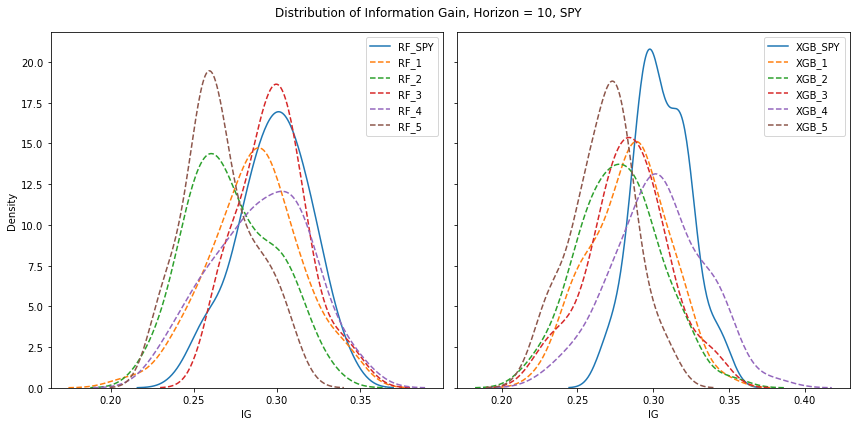

In [378]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Distribution of Information Gain, Horizon = 10, SPY')    
sns.distplot([etf_df['RF_'+'SPY']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'SPY');
sns.distplot([random_etf_df['RF_'+'1']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'1',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'2']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'2',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'3']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'3',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'4']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'4',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['RF_'+'5']],kde=True,hist=False,ax = axes[0],label = 'RF_'+'5',kde_kws={'linestyle':'--'});
axes[0].set_xlabel('IG')
axes[0].legend()

sns.distplot([etf_df['XGB_'+'SPY']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'SPY');
sns.distplot([random_etf_df['XGB_'+'1']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'1',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'2']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'2',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'3']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'3',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'4']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'4',kde_kws={'linestyle':'--'});
sns.distplot([random_etf_df['XGB_'+'5']],kde=True,hist=False,ax = axes[1],label = 'XGB_'+'5',kde_kws={'linestyle':'--'});
axes[1].set_xlabel('IG')
axes[1].legend()

plt.tight_layout()
plt.savefig(plotfolder+'/horizon10_dist.png')


## Conclusion and Future Work

### Daily Analysis

We find a signal in **SPY, OIH, IWM, IYR, LQD**. In most of the cases RF or XGB algorithm gives a positive signal. 

However before making such a bold claim it's important to remember that our analysis only suggests that we might be able to get better accuracy compared to a random ETF, however our returns could be worse compared to zero. Also we only consider 5 different random ETF's. It's possible that considering more, we would get a p-value above our threshold of 0.05. A more detailed statistical analysis is needed to address this question. It is of interest why this method works on certain ETF's and not others and should be investigated further.

Finally we need to implement this strategy in live markets to see it's potential. We will implement this in the future. For future work we will consider following improvements.
Increase horizon size and combine ETF's together, keeping the features the same.
- Macroeconomic data such as employment numbers, retail sales, industrial production, consumer confidence etc.
- Use NLP to scan financial news headlines and generate features (This is harder than it sounds because each ETF represents a collection of different companies which different news sources can affect)
- Try different algorithms (Neural Nets, Stacking etc.)
- If a significant signal is found, try running the algorithm on active markets

### Combined ETF Analysis

When we combine the ETF's we see a signal even for horizon of one day for most of our ETF's.  For SPY however as we increased the horizon size for our predictions, the predictions got worse with no prediciton compared to the random ETF's for horizon size of 10. This is contrary to what's shown in Liew and Mayster. It is not clear why we reach different conclusions. A difference could be because they complain that their information gain to a randomly generated distribution from univariate variables, but we compare it to a random walk which should be a better comparison in theory. This needs to be investigated further.


Increasing horizon size could give a larger gain for most ETF's however it's important to remember once again that our analysis only suggests that we might be able to get better accuracy compared to a random ETF, however our returns could be worse compared to zero. Increasing horizon size could also mean lower overall returns, even for higher accuracy since profits compund. The ideal horizon should be investigated. We should also see if this stands the test of live markets.
